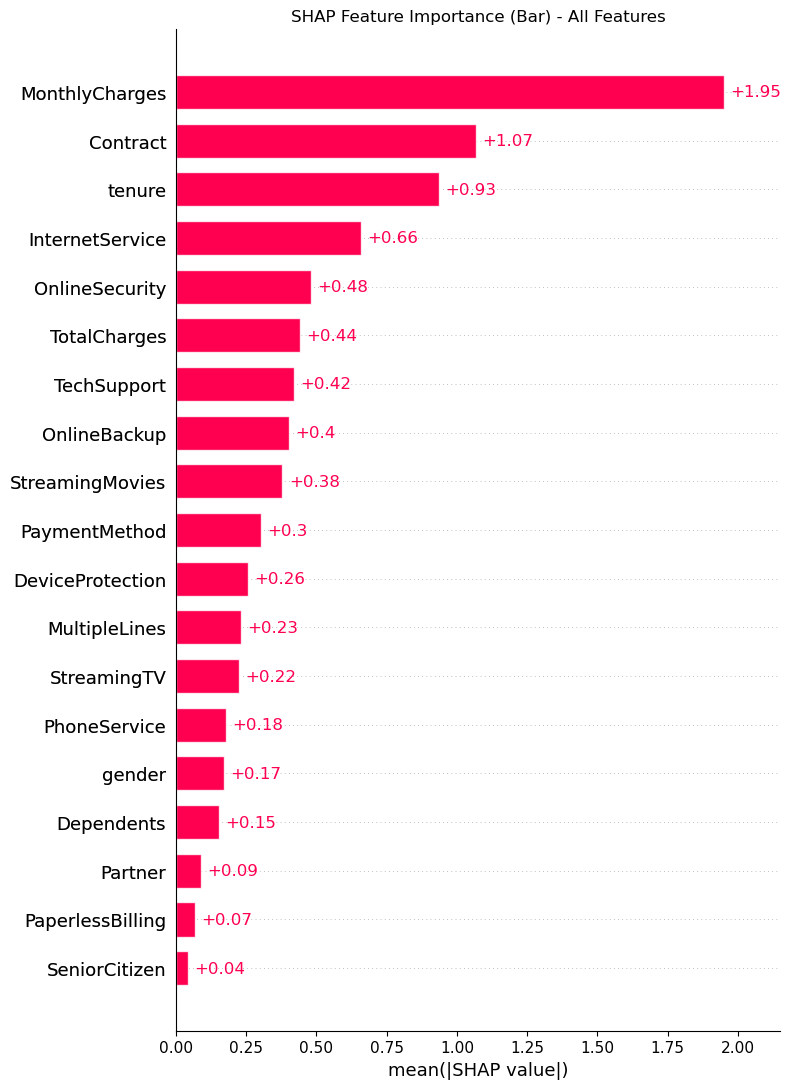

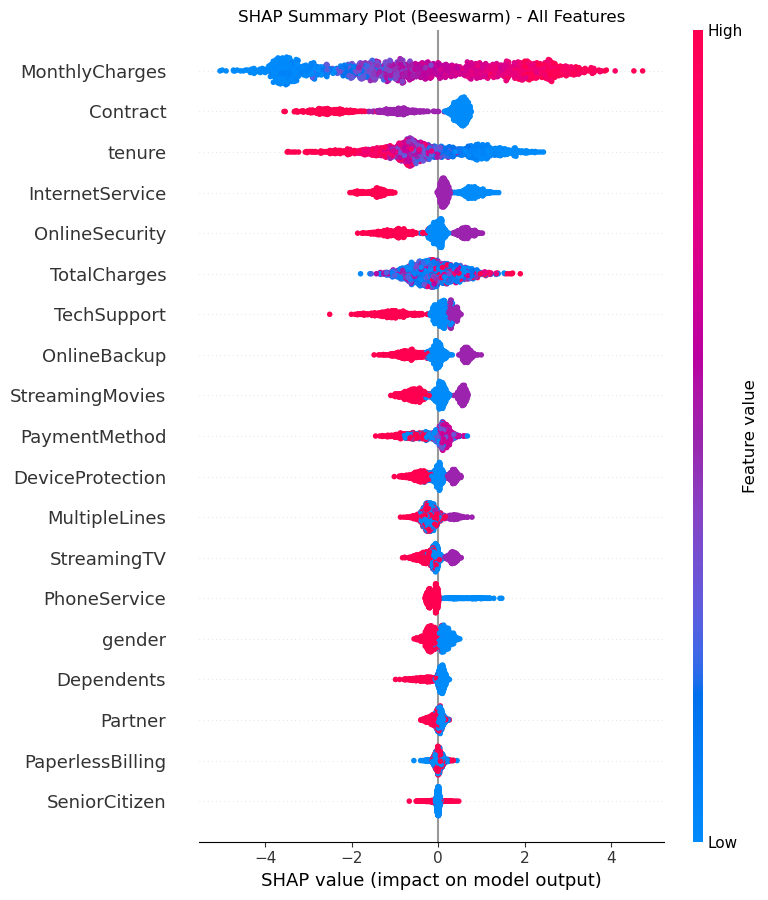

In [3]:
import shap
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import os

# Create plots directory if not exists
os.makedirs("../plots", exist_ok=True)

# Load dataset
df = pd.read_csv("../data/Telecom Customers Churn.csv")
df.drop("customerID", axis=1, inplace=True)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(inplace=True)
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

# Encode categorical columns
categorical_cols = df.select_dtypes(include="object").columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Use all features
X = df.drop("Churn", axis=1)
y = df["Churn"]
feature_names = X.columns.tolist()

# Train-test split and preprocessing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost
model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train_scaled, y_train)

# SHAP analysis
explainer = shap.Explainer(model, X_train_scaled, feature_names=feature_names)
shap_values = explainer(X_test_scaled)

# --- Plot SHAP Bar ---
plt.figure()
shap.plots.bar(shap_values, max_display=len(feature_names), show=False)
plt.title("SHAP Feature Importance (Bar) - All Features")
plt.tight_layout()
plt.savefig("../plots/shap_bar_all_features.png")
plt.show()

# --- Plot SHAP Beeswarm ---
plt.figure()
shap.plots.beeswarm(shap_values, max_display=len(feature_names), show=False)
plt.title("SHAP Summary Plot (Beeswarm) - All Features")
plt.tight_layout()
plt.savefig("../plots/shap_summary_all_features.png")
plt.show()
